# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/8f/b7/f329cfdc75f3d28d12c65980e4469e2fa373f1953f5df6e370e84ea2e875/decorator-4.4.1-py2.py3-none-any.whl


In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import numpy.linalg as LA
from sklearn.neighbors import KDTree

%matplotlib inline
%config IPCompleter.greedy = True

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [6]:
from sampling import Sampler
sampler = Sampler(data)
polygons = sampler.polygons
pts = sampler.sample(500)
print(len(pts))

321


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [52]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
def can_connect(p1,p2):
    ls = LineString([p1,p2])
    for poly in polygons:
        #if poly.crosses(ls) and poly.height >= min(p1[2], p2[2]):
        if poly.crosses(ls):
            return False
    return True

def create_graph(pts, k):
    g = nx.Graph()
    tree = KDTree(pts)
    for p1 in pts:
        idxs = tree.query([p1], k, return_distance=False)[0]
        for idx in idxs: 
            p2 = pts[int(idx)]
            if p1 == p2:
                continue
            if can_connect(p1,p2):
                g.add_edge(p1,p2, weight=(np.linalg.norm(np.array(p2)-np.array(p1))))
                
    return g

In [61]:
import time
t0 = time.time()
g = create_graph(pts, 12)
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 37.74311184883118 seconds to build


## Step 4 - Visualize Graph

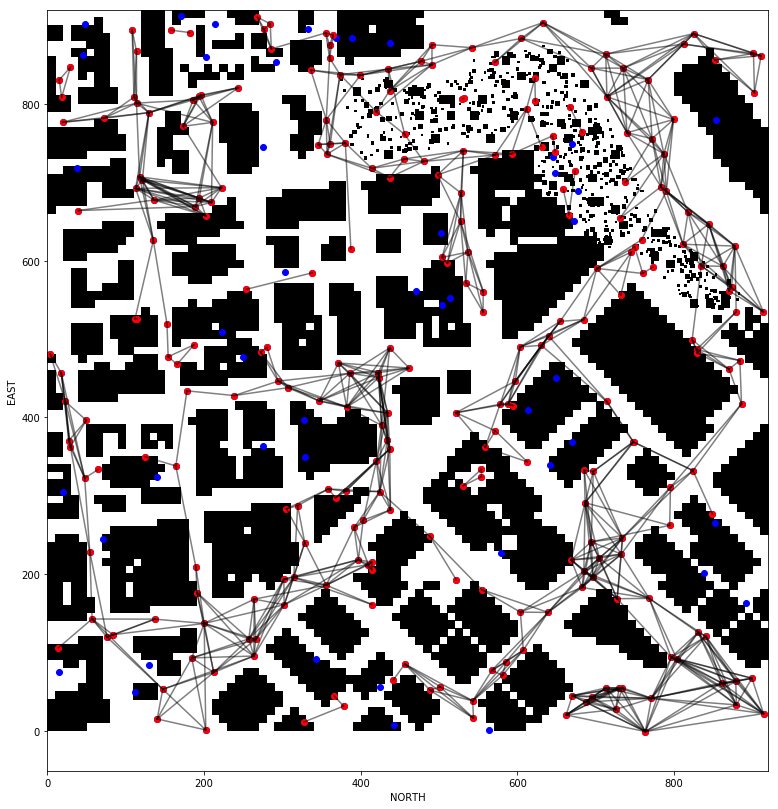

In [71]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 0)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in pts:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()


## Step 5 - Define Heuristic

In [10]:
def heuristic(n1, n2):
    return np.linalg.norm(np.array(n2)-np.array(n1))

## Step 6 - Complete A*

In [24]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""

    queue = PriorityQueue()
    queue.put((0,start))
    visited = set(start)
    branch = {}
    
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0
        else:
            current_cost = branch[current_node][0]
         
        if current_node == goal:
            found = True
            break
        else:
            for neighbor in graph[current_node]:
                g_cost = current_cost + graph[current_node][neighbor]['weight']
                f_cost = g_cost + heuristic(neighbor, goal)

                if neighbor not in visited: 
                    visited.add(neighbor)
                    queue.put((f_cost, neighbor))
                    branch[neighbor] = (g_cost, current_node)
        
        
    path = []
    path_cost = 0
    if found:
        p = goal
        path_cost = branch[p][0]
        while p != start:
            path.append(p)
            p = branch[p][1]
        path.append(start)
    else:
        print("No path found")
    return path[::-1], path_cost



In [67]:
#start = [200 + nmin, 0 + emin, 10]
#idx = np.argmin(np.linalg.norm(np.array(g.nodes) - start, axis = 1))
k = np.random.randint(len(g.nodes))
start = list(g.nodes)[k]
goal = list(g.nodes)[len(g.nodes)-1]
print(start, goal)

(-95.22829206576299, -25.232428851283657, 2.6455897468171674) (304.85089175779666, -51.76398031573024, 9.774881245173896)


In [68]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

25 [(-95.22829206576299, -25.232428851283657, 2.6455897468171674), (-98.28039946248737, -29.434042842823374, 8.982513646890082), (-50.784770601647324, -47.620689030812514, 16.891127419403393), (-5.062614512135497, -14.844952858794386, 11.406437792004606), (-61.86571184192965, 48.86524412223838, 11.849486219566687), (-130.41364028816153, 115.67694175818133, 11.357152502271521), (-159.01273779646493, 164.7214551700938, 8.934281106148179), (-107.02635214719115, 245.7271231341564, 15.135124085175688), (-64.23633670353934, 295.0499933745224, 6.333165371220797), (0.5131801185667086, 356.3983645086605, 12.354568091360395), (106.93378691978978, 447.1145339512185, 9.737261014694848), (151.24212628808664, 431.18899003954937, 15.226573543820912), (188.7201798846943, 384.03642776942263, 16.71901971238148), (283.2158165505263, 395.6532337900625, 16.01669026370908), (310.7960185510755, 372.45605521972357, 6.0185662801164685), (384.2640215699051, 344.2265724637615, 11.68157559255637), (453.1894955161

## Step 7 - Visualize Path

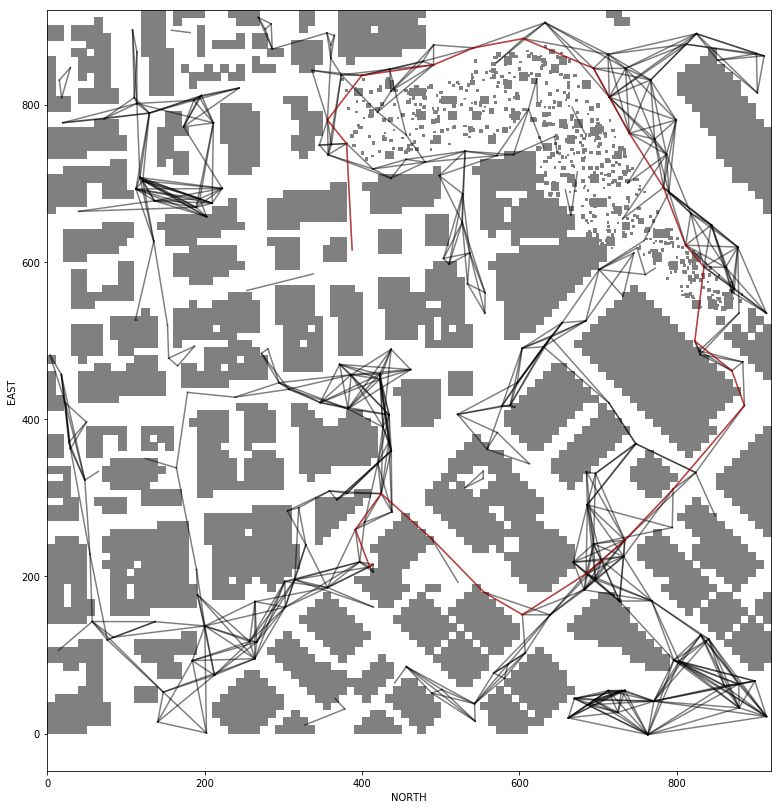

In [72]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower', alpha = .5)

for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=.5)

for i in range(len(path)-1):
    n1 = path[i]
    n2 = path[i+1]
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'red' , alpha=.5)
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)